## GOOSE

This is a tutorial for a model of the Geologic Carbon Cycle during Snowball Earth (GOOSE). Created by Trent Thomas and David Catling.

Here we show how to run the model once with a set of input parameters.

### Imports

First, bring in the standard libraries. We'll use xarray and pandas for most of the data handling.

In [1]:
import sys
import time
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint # pretty print
import matplotlib.pyplot as plt

Next, bring in the functions. Each function here has the model configured for the 4 phases.

In [7]:
from functions import neoproterozoic_1boxmodel as neo # Phase 1: Neoproterozoic background steady state
from functions import snowball_1boxmodel as snow # Phase 2: Snowball
from functions import poststrat_2boxmodel as strat # Phase 3: Stratified post-glacial ocean
from functions import postmixed_1boxmodel as mixed # Phase 4: Well-mixed post-glacial ocean

## Input File

Model inputs are contained in a seperate inputFile .py file that defines a class called `inputs`. The default inputFile has most of the inputs randomized within reasonable ranges, which is necessary for model testing. This class also takes care of calibrating the model to the modern climate once parameters are set, which is required in order to model several processes in the geologic carbon cycle.

In [2]:
import inputFile_randomized as inputFile # Select input file here

inp = inputFile.inputs("Tutorial Inputs") # Define the input structure and name the model run

seed = 39 # Set the random seed for reproducability within this tutorial
inp.shuffle(seed) # Generate the input values, before this, the inp structure is empty
inp.calibrate_to_modern() # Calibrate model parameters assuming one box modern steady state
pprint(inp.__dict__)

{'E_bas': 97.02655521890654,
 'O_sink': 178219782096772.9,
 'V_frac_modern': 0.75,
 'a_grad': 1.1612012040748627,
 'carb_n': 1.7882718750468756,
 'carb_xi': 0.28556336232402735,
 'cont_Te': 28.98138528631994,
 'f_w': 0.914830796351021,
 'hyalo': 1,
 'k_Wsea': 291705737196.17523,
 'k_pel': 644433225626.0376,
 'k_pore': 126560850576.23857,
 'k_shelf': 2933937797332.8555,
 'meltwater_Ca': 0.00029359876586299884,
 'meltwater_alk': 0.0008777052708475126,
 'meltwater_mass': 3.5796922982185055e+20,
 'meltwater_s': 0.502836514997616,
 'modern_Ao': 0.0017482209860918748,
 'modern_Ap': 0.00172280703383006,
 'modern_Ca_ocean': 0.01027,
 'modern_Ca_pore': 0.010257293023869093,
 'modern_Co': 0.0016762073410591192,
 'modern_Cp': 0.0016052532334073957,
 'modern_Hp': 5.450319166067374e-09,
 'modern_J': 1.338458167972218e+16,
 'modern_K': 9.6e+17,
 'modern_P_ocean': 21984409244419.09,
 'modern_P_pore': 450000000000.0,
 'modern_Ts': 285,
 'modern_V': 9691596085130.422,
 'modern_W_carb': 12742813159288.6

That's a lot of parameters! Go into the input file and look at the comment for more information on what each one means. Fortunately we can easily change any of them from right here in the notebook, like this:

In [3]:
inp.f_w = 1.5 # Set the weatherability factor to 1.5
inp.t_strat = 1e4 # Set the duration of post-glacial ocean stratification

If you set any new parameters, make sure you refresh the input structure so that downstream calculations and calibration is still accurate.

In [4]:
inp.redo_calculations() # make sure fixed parameters are incorporated in downstream parameter calcs

## Set up the data storage

We use this dummy class to group things up and make handling easier. We are approximating the functionality of a matlab struct.

In [5]:
class ODE_full_output:
    def __init__(self) -> None:
        pass

model_output = ODE_full_output()

## PHASE 1: Neoproterozoic steady state

In [8]:
neo_output = neo.neoproterozoic_ss(inp,'RK45')
model_output.neo_output = neo_output

#model_output.neo_output.__dict__

## PHASE 2: Snowball

In [9]:
snow_init_conds = [neo_output.data['Co'][0]/(1-inp.snowball_ice_volume), \
            neo_output.data['Ao'][0]/(1-inp.snowball_ice_volume), \
            neo_output.data['Cp'][0], neo_output.data['Ap'][0]] # calculate change in ocean chemistry due to shrinking ocean

snow_max_duration = 10e6 # how long does the snowball evolution last? [yr]
co2_threshold = False # deglaciate at some CO2 threshold? [False] or give the threshold in [bar]

snow_output = snow.snowball_evol(inp,'RK45',snow_init_conds,snow_max_duration,co2_threshold)
model_output.snow_output = snow_output

#model_output.snow_output.__dict__

/Users/tthomas/Documents/research/neoproterozoic-cap_carbonates/GOOSE_github/functions/chemistry.py:126: RuntimeWarning: invalid value encountered in log10
  pH = -np.log10(H_ion)  # equation S16 (aka pH definition)


Sometimes a warning appears ^here^ when the model is pushed to extremes.

## PHASE 3: Post-glacial stratified ocean

In [10]:
Cs_strat = inp.meltwater_s*snow_output.data["pCO2_o"].iloc[-1] # all carbon in meltwater comes from existing CO2
DIC_o_strat = snow_output.data["Co"].iloc[-1] - (inp.snowball_s*snow_output.data["pCO2_o"].iloc[-1]) # all carbon in deep ocean is the DIC from subglacial ocean

strat_init_conds = [Cs_strat,inp.meltwater_alk, \
                DIC_o_strat, snow_output.data["Ao"].iloc[-1], \
                snow_output.data["Cp"].iloc[-1], snow_output.data["Ap"].iloc[-1]]

strat_max_duration = inp.t_strat # post-glacial evolution duration

strat_output = strat.poststrat_evol(inp,'RK45',strat_init_conds,strat_max_duration)
model_output.strat_output = strat_output

#model_output.strat_output.__dict__

## PHASE 4: Post-glacial well-mixed ocean

In [11]:
# Average together surface and deep ocean carbon and alkalinity
Co_mixed = ((strat_output.data["Cs"].iloc[-1]*inp.meltwater_mass) + (strat_output.data["Cd"].iloc[-1]*inp.snowball_ocean_mass))/inp.modern_ocean_mass
Ao_mixed = ((strat_output.data["As"].iloc[-1]*inp.meltwater_mass) + (strat_output.data["Ad"].iloc[-1]*inp.snowball_ocean_mass))/inp.modern_ocean_mass

mixed_init_conds = [Co_mixed, Ao_mixed, strat_output.data["Cp"].iloc[-1], strat_output.data["Ap"].iloc[-1]]

mixed_max_duration = 30e6 # give it 30 Myr to reach a steady state

mixed_output = mixed.postmixed_evol(inp,'RK45',mixed_init_conds,mixed_max_duration)
model_output.mixed_output = mixed_output

# model_output.mixed_output.__dict__

# SINGLE MODEL RUN COMPLETE - PLOTTING BELOW

In [12]:
pprint(model_output.__dict__)

{'mixed_output': <functions.postmixed_1boxmodel.ODE_full_output object at 0x13608aed0>,
 'neo_output': <functions.neoproterozoic_1boxmodel.ODE_full_output object at 0x137c63980>,
 'snow_output': <functions.snowball_1boxmodel.ODE_full_output object at 0x137bec680>,
 'strat_output': <functions.poststrat_2boxmodel.ODE_full_output object at 0x16815c890>}


In [13]:
# Extract data
neop_data = model_output.neo_output.data
snow_data = model_output.snow_output.data
stra_data = model_output.strat_output.data
mixe_data = model_output.mixed_output.data

# Print the columns of the data frames - see paper for variable descriptions
print("Snow_data vars: \n",snow_data.columns.values)
print("\n Strat_data vars: \n",stra_data.columns.values)
print("\n Mixed_data vars: \n",mixe_data.columns.values)

Snow_data vars: 
 ['t' 'Co' 'Ao' 'Cp' 'Ap' 'Ts' 'Td' 'Tp' 'pCO2_o' 'pCO2_p' 'Omega_o'
 'Omega_p' 'pH_o' 'pH_p' 'V' 'P_ocean' 'P_pore' 'W_carb' 'W_sil' 'W_sea']

 Strat_data vars: 
 ['t' 'Cs' 'As' 'Cd' 'Ad' 'Cp' 'Ap' 'Ts' 'Td' 'Tp' 'pCO2_s' 'pCO2_d'
 'pCO2_p' 'Omega_s' 'Omega_d' 'Omega_p' 'pH_s' 'pH_d' 'pH_p' 'V_air'
 'V_ridge' 'P_shelf' 'P_pore' 'W_carb' 'W_sil' 'W_sea' 'O_sink']

 Mixed_data vars: 
 ['t' 'Co' 'Ao' 'Cp' 'Ap' 'Ts' 'Td' 'Tp' 'pCO2_o' 'pCO2_p' 'Omega_o'
 'Omega_p' 'pH_o' 'pH_p' 'V' 'P_shelf' 'P_pore' 'W_carb' 'W_sil' 'W_sea']


## Bring in some plotting functions

In [14]:
# Uncomment to refresh the plotting function if changes were made
# import importlib
# importlib.reload(pu)

from functions import plotUtilsSolo as pu

### Plot 1: Global climate evolution through all phases

We want pCO2, sea surface temp, pH, omega, alkalinity

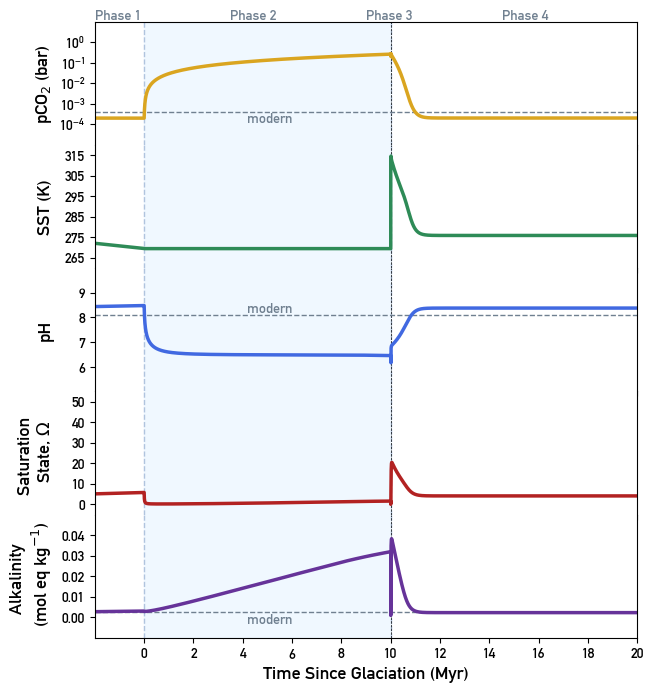

In [15]:
pu.plotFullClimEvol_solo(model_output)

### Plot 2: Global climate evolution during the stratified ocean phase

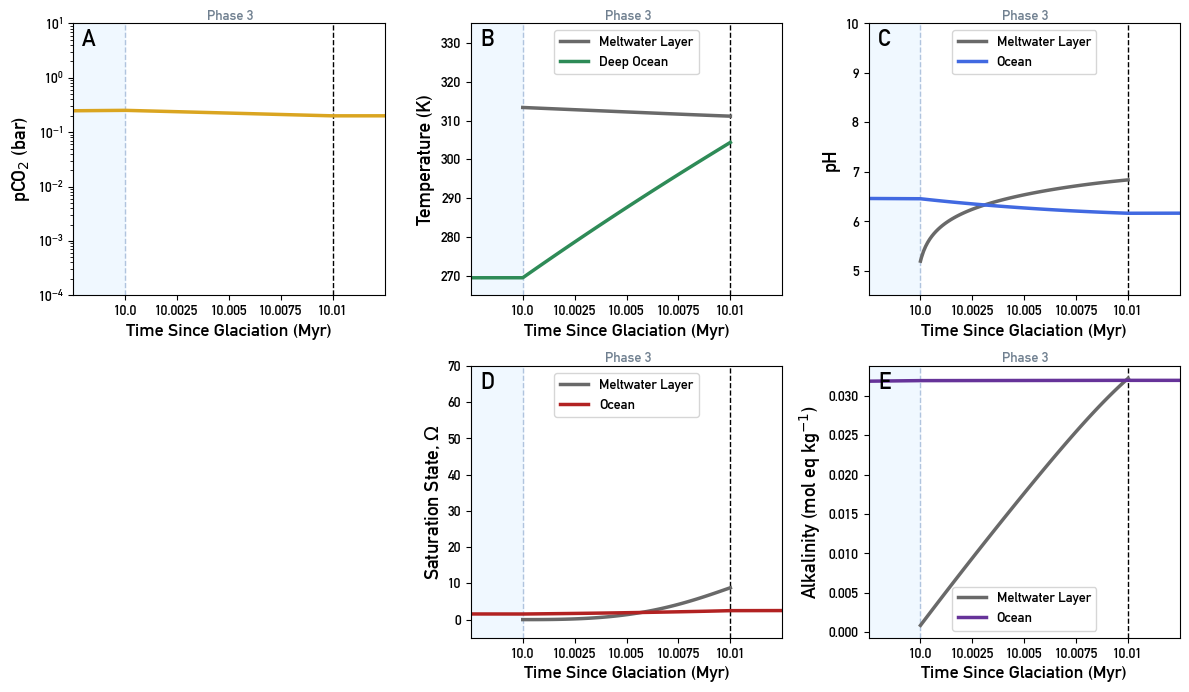

In [16]:
pu.plotStratClimEvol_solo(model_output)

### Plot 3: Post-glacial carbonate deposition - mass

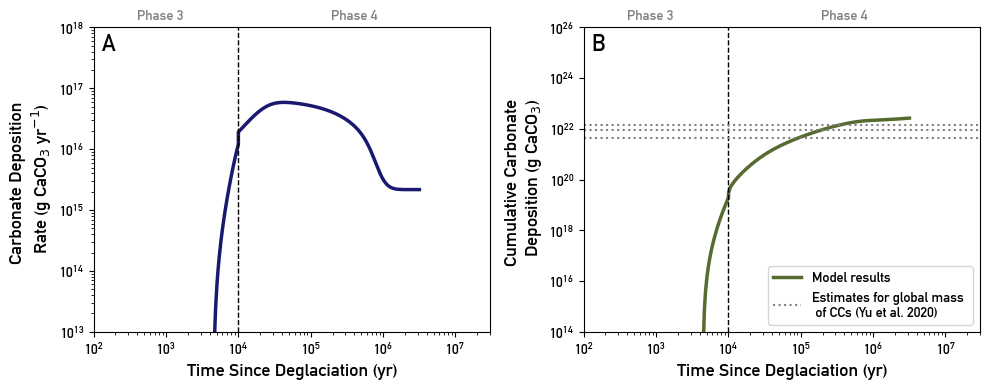

In [17]:
pu.plotPostGlacialCarbMass_solo(model_output)

### Plot 4: Post-glacial carbonate deposition - height

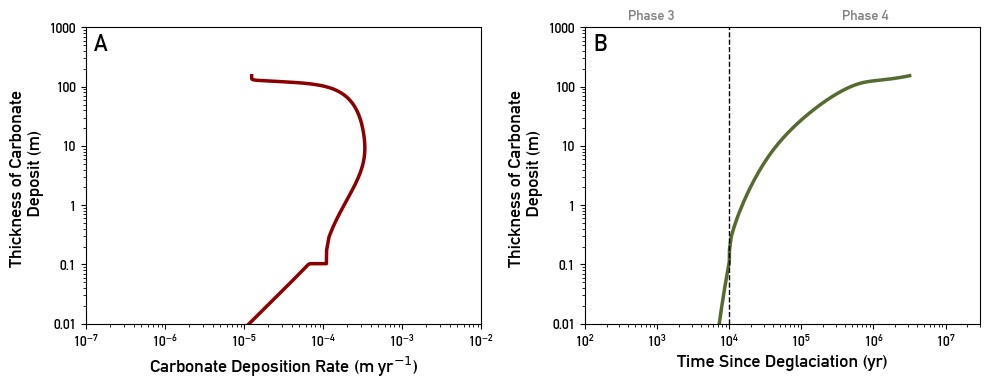

In [18]:
pu.plotPostGlacialCarbHeight_solo(model_output)

### Plot 5: Fluxes

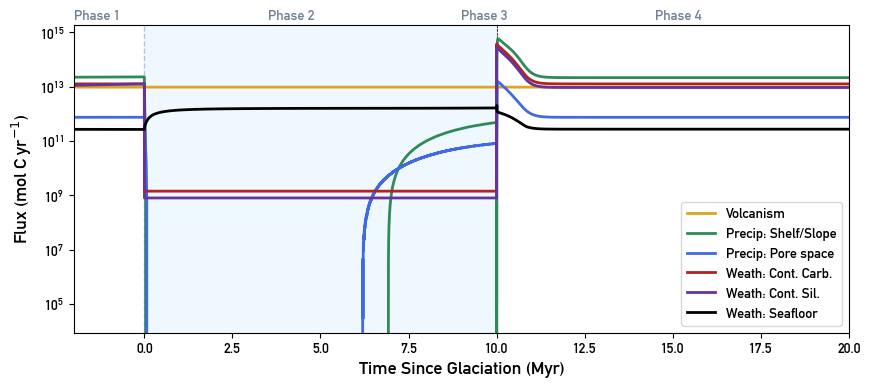

In [19]:
pu.plotFluxes_solo(model_output)